## 5 - LSTM (inbuilt PyTorch module): Name Origin Classification

We will observe better result in LSTM in comparison to simple RNN

In [1]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import glob  #helpful in finding pathnames following specific pattern
import unicodedata
import string
import os
import random
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

### Preparing data and making its tensors

In [3]:
def findTxtFiles(path_pattern):
    return glob.glob(path_pattern)

In [4]:
path_pattern = "./rnn_data/names/*.txt"
files = findTxtFiles(path_pattern)

In [5]:
files

['./rnn_data/names/Czech.txt',
 './rnn_data/names/Dutch.txt',
 './rnn_data/names/Korean.txt',
 './rnn_data/names/Russian.txt',
 './rnn_data/names/Scottish.txt',
 './rnn_data/names/Spanish.txt',
 './rnn_data/names/Greek.txt',
 './rnn_data/names/Vietnamese.txt',
 './rnn_data/names/Irish.txt',
 './rnn_data/names/German.txt',
 './rnn_data/names/Polish.txt',
 './rnn_data/names/French.txt',
 './rnn_data/names/Portuguese.txt',
 './rnn_data/names/Chinese.txt',
 './rnn_data/names/Italian.txt',
 './rnn_data/names/Arabic.txt',
 './rnn_data/names/English.txt',
 './rnn_data/names/Japanese.txt']

In [6]:
class_list = []
word_class_dict = {}

In [7]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters)
def readTxt(file):
    lines = open(file, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for file in files:
    class_name = os.path.splitext(os.path.basename(file))[0]
    class_list.append(class_name)
    lines = readTxt(file)
    word_class_dict[class_name] = lines

In [8]:
word_class_dict['French'][:5]

['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']

In [9]:
n_class = len(class_list)

In [10]:
#preparing character-wise tensor
print(all_letters.index('g'))


def letter2index(letter):
    return all_letters.index(letter)
def letter2tensor(letter):
    idx = letter2index(letter)
    x = torch.zeros(1,n_letters)
    x[0][idx]=1
    return x
def name2tensor(name):
    n_name = len(name)
    x = torch.zeros(n_name,1,n_letters)
    for i,letter in enumerate(name):
        x[i][0][letter2index(letter)]=1
    return x

6


In [11]:
name2tensor('ashish')

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

### Auxillary Functions

In [12]:
def predictClass(output):
    max_val,max_idx = output.topk(1)
    class_idx = max_idx[0].item()
    return class_list[class_idx],class_idx

# give random choice index in a list
def makeRandomChoice(l):
    return random.randint(0,len(l)-1)



def makeRandomExampleTensor():
    choose_class = class_list[makeRandomChoice(class_list)]
    choose_word = word_class_dict[choose_class][makeRandomChoice(word_class_dict[choose_class])]
    y = torch.tensor([class_list.index(choose_class)],dtype=torch.long)
    X = name2tensor(choose_word)
    return choose_class,choose_word,X,y


            
def initCuda(force_cpu=True):
    ## Do check for cuda device
    if torch.cuda.is_available() and force_cpu==False:
        device = torch.device("cuda:0")
        print("GPU Process")
    elif force_cpu:
        device = torch.device("cpu")
        print("CPU Process")
    else:
        device = torch.device("cpu")
        print("CPU Process")
    return device


### RNN duing LSTM cell Architecture

In [127]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        #Layers
        self.input_hidden = nn.LSTM(self.input_size,self.hidden_size)
        self.hidden_output = nn.Linear(self.hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    #forward gives us recursion by prev_hidden arguement!
    def forward(self,data, prev_hidden):
        #lstm(input,(h_0,c_0))
        lstm_out,hidden = self.input_hidden(data,prev_hidden)
        #hidden = F.relu(hidden)
        output = self.hidden_output(lstm_out[-1])
        output = self.softmax(output)
        return output,hidden
    
    #h_0 of shape  - (num_layers * num_directions, batch, hidden_size)
    #c_0 of shape - (num_layers * num_directions, batch, hidden_size
    def init_hidden(self):
        #return tuple of (h_0,c_0)
        return (torch.zeros(1, 1, self.hidden_size).to(device),
                torch.zeros(1, 1, self.hidden_size).to(device))
    

    
###Training Function

def train(model,n_iters):
    loss_tracker = []
    for i in tqdm(range(n_iters)):
        hidden = model.init_hidden()
        _,_,X,y = makeRandomExampleTensor()
        X=X.to(device)
        y=y.to(device)
        model.zero_grad()
        
        output,hidden = model(X,hidden)
        #output.to(device)
        #hidden
            #print(output)
            #print(y)
        loss = criterion(output,y)
        loss.backward()
        optimizer.step()
        if i%5000==0:
            loss_tracker.append(loss)    
    return loss_tracker
    

In [128]:
device = initCuda(False)

GPU Process


In [129]:
device

device(type='cuda', index=0)

In [130]:
hidden_size = 128
rnn = RNN(n_letters,hidden_size,n_class).to(device)
print(rnn)

RNN(
  (input_hidden): LSTM(57, 128)
  (hidden_output): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)


In [131]:
next(rnn.parameters()).is_cuda

True

In [132]:
import torch.optim as optim
optimizer = optim.Adam(rnn.parameters(),lr=0.001)
criterion = nn.NLLLoss()

In [133]:
loss_plot = train(rnn,250000)

100%|██████████| 250000/250000 [08:03<00:00, 517.09it/s]


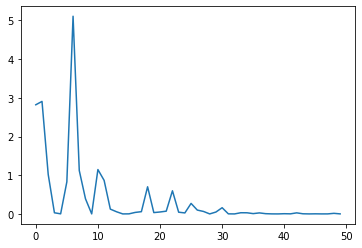

In [134]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.plot(loss_plot)
plt.show()

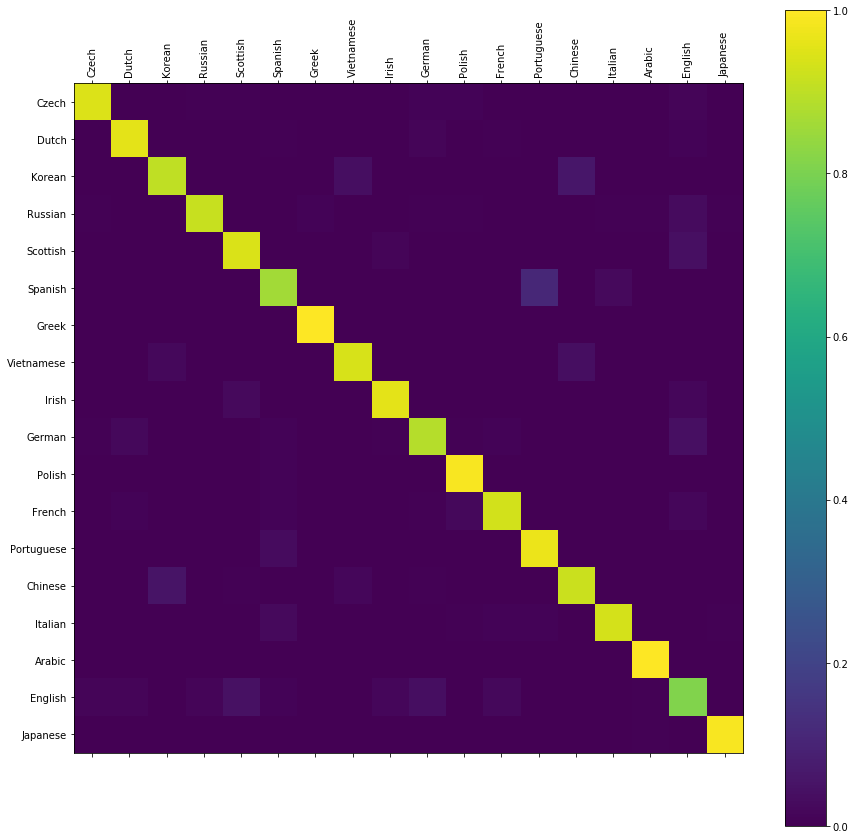

In [135]:
# Copied as it is from 60 min blitz
confusion = torch.zeros(n_class, n_class)
n_confusion = 10000
all_categories=class_list
n_categories = n_class
# Just return an output given a line
def evaluate(line_tensor):
    with torch.no_grad():
        hidden = rnn.init_hidden()

        output, hidden = rnn(line_tensor, hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, line_tensor,category_tensor = makeRandomExampleTensor()
    #print(line_tensor)
    output = evaluate(line_tensor.to(device))
    guess, guess_i = predictClass(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()